<a href="https://colab.research.google.com/github/shimjaeman/PyTorch-Tutorials/blob/main/03_Pytorch_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

선형 회귀(Linear Regression)

1. 선형회귀의 가설 (직선 방정식)
  - H(x) = Wx + b
  - W(weight) : 가중치
  - b(bias) : 편향 

2. 비용함수 (Cost Function)
  - 각 실제값과 직선의 예측값에 대한 값의 차이의 제곱(or 절대값)의 합 
  - Cost = loss = error = objective
  - 
  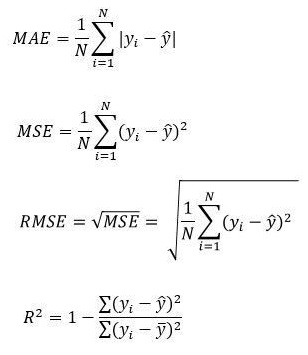
  - 즉, Cost(W,b)를 최소가 되게 만드는 W와 b를 구하면 훈련 데이터를 가장 잘 나타내는 직선

  3. 옵티마이저 - 경사 하강법(Gradient Descent)
  - 비용 함수(Cost function)를 미분하여 현재 W에서의 접선의 기울기를 구하고, 접선의 기울기가 낮은 방향으로 W의 값을 변경하는 작업을 반복하는 것
  - 기울기가 양수라면 음의 방향 
  - 기울기가 음수라면 양의 방향
  - 학습률 (Learning Late)
    * w = (w - 런닝메이트 * 미분)
    * 값을 변경할 때, 얼마나 크게 변경할지를 결정
    *  학습률이 너무 작을 경우, (step size가 작을 수록)
      1. 알고리즘이 수렴하기 위해 반복해야 하는 값이 많으므로 학습시간이 오래걸림.
      2. 지역 최소값(local minimum)에 수렴할 수 있음.
    * 학습률이 너무 클 경우, (step size가 클수록)
      1. 학습 시간은 적게 걸림.
      2. 스텝이 너무 커서 전역 최소값 (global minimum)을 가로질러 반대편으로 건너뛰어 최소값에서 멀어질 수 있음.
    * 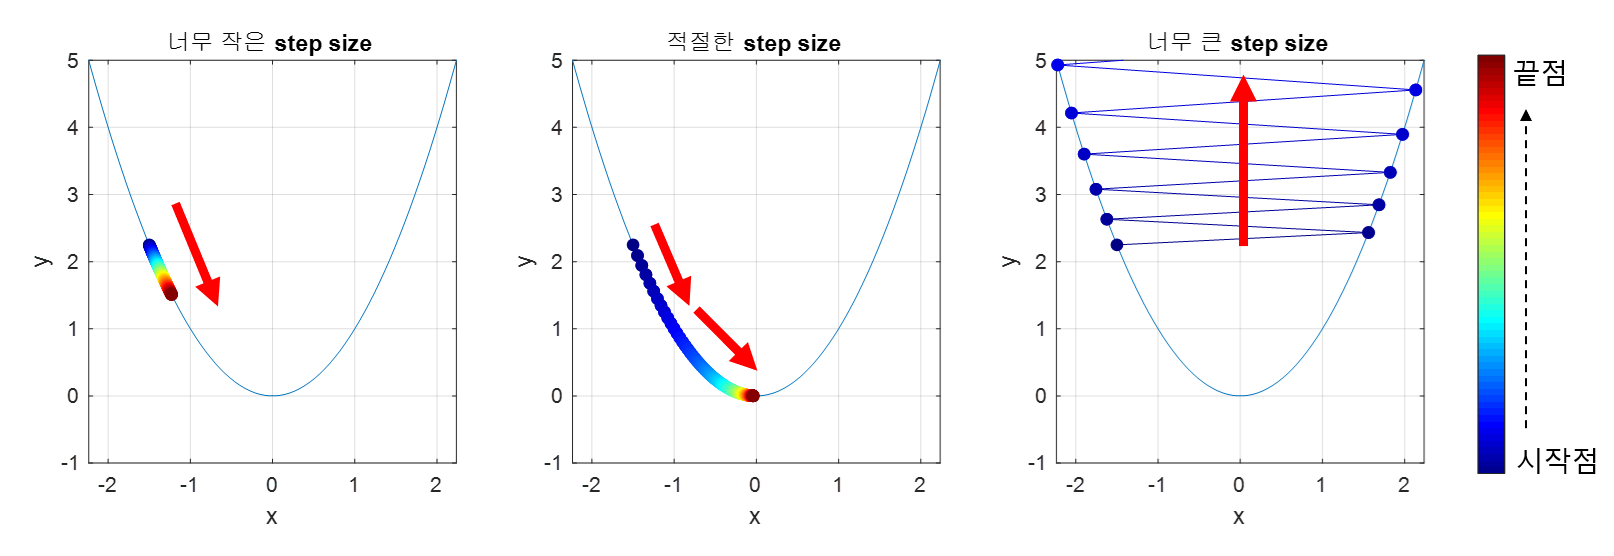
  

# Neural Network


> Data Loader 



Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다.

DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.


In [39]:
# 기본 라이브러리
import numpy as np
import pandas as pd

# Pytorch 라이브러리
import torch
import torch.nn as nn # SGD, Adam 등과 같은 optimizer
import torch.optim as optim # 모든 neural network 모듈
import torch.nn.functional as F # Parameterless functions
from torch.utils.data import DataLoader # 미니배치를 생성하여 쉽게 데이터 셋 처리
import torchvision.datasets as datasets 
import torchvision.transforms as transforms # augumetation을 위해 데이터 세트에서 수행할 수 있는 변환
from tqdm import tqdm  # progress bar (진행상황 확인)

In [40]:
# 파이썬 코드를 재실행해도 같은 결과가 나오도록 랜덤 시드(random seed) 설정
torch.manual_seed(1)

In [41]:
### MNIST dataset 
# input_size: the size of the input, in this case 784 (28x28)
# num_classes: the number of classes we want to predict, in this case 10 (0-9)
class NN (nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__() # super : 상속 관계에서 상속의 대상인 부모 클래스를 호출하는 함수
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

In [42]:
# class test
model = NN(784, 10)
x = torch.randn(64, 784) # Mnist x : [64, 1, 28, 28]
model(x).shape

torch.Size([64, 10])

In [43]:
# Set device (Cuda / cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [52]:
# Load Data
train_dataset = datasets.MNIST (root = "dataset/", train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST (root = "dataset/", train=False, transform = transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size = batch_size)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size = batch_size)

In [53]:
# model creating
model = NN(input_size, num_classes).to(device)
model

NN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [54]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

100%|██████████| 938/938 [00:07<00:00, 121.69it/s]


In [56]:
# Check accuracy on training & test 
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() # eval mode에서 사용할 것이라고 모든 레이어에 선언하는 것

    # torch.no_grad() : 검증단계에서는 backprop을 하지 않을 것이기 때문에 
    # no_grad()로 감싸주고 이는 이 블럭 안에서는 그래디언트 트래킹을 안해도 된다 라고 선언 
    # ===> 메모리& 시간 감소
    with torch.no_grad():
        for x, y in tqdm(loader):

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
            x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train() # eval => train 
    return num_correct / num_samples

In [57]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"\nAccuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

100%|██████████| 938/938 [00:06<00:00, 142.34it/s]


Accuracy on training set: 98.85


100%|██████████| 157/157 [00:01<00:00, 140.07it/s]


Accuracy on test set: 97.29
